In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

In [2]:
folder_location = '../results/toxic_measures/'

original = json.load(open(f'{folder_location}original.json'))
modern = json.load(open(f'{folder_location}modern.json'))

opt_first_line = json.load(open(f'{folder_location}opt_first_line.json'))
opt_256_tokens = json.load(open(f'{folder_location}opt_256_tokens.json'))
opt_512_tokens = json.load(open(f'{folder_location}opt_512_tokens.json'))

llama_first_line = json.load(open(f'{folder_location}llama_first_line.json'))
llama_256_tokens = json.load(open(f'{folder_location}llama_256_tokens.json'))
llama_512_tokens = json.load(open(f'{folder_location}llama_512_tokens.json'))

alpaca_1 = json.load(open(f'{folder_location}alpaca_1.json'))
alpaca_3 = json.load(open(f'{folder_location}alpaca_3.json'))

alpaca_free_2 = json.load(open(f'{folder_location}alpaca_free_2.json'))
alpaca_free_4 = json.load(open(f'{folder_location}alpaca_free_4.json'))

def convert_to_single(dic):
    vals = {
        'toxic': [],
        'severe_toxic': [],
        'obscene': [],
        'threat': [],
        'insult': [],
        'identity_hate': [],
    }
    
    for e1 in dic:
        for e2 in e1:
            vals[e2['label']].append(e2['score'])
    return vals

original = convert_to_single(original)

modern = convert_to_single(modern)

opt_first_line = convert_to_single(opt_first_line)
opt_256_tokens = convert_to_single(opt_256_tokens)
opt_512_tokens = convert_to_single(opt_512_tokens)

llama_first_line = convert_to_single(llama_first_line)
llama_256_tokens = convert_to_single(llama_256_tokens)
llama_512_tokens = convert_to_single(llama_512_tokens)

alpaca_1 = convert_to_single(alpaca_1)
alpaca_3 = convert_to_single(alpaca_3)

alpaca_free_2 = convert_to_single(alpaca_free_2)
alpaca_free_4 = convert_to_single(alpaca_free_4)

In [114]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, interpolation='none', **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [121]:
def get_normalized(d):
    return [float(i)/sum(d) for i in d]

def generate_hmaps(label='toxic'):
    bin_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    # bin_labels = [0, 0.2, 0.4, 0.6,0.8,1.0]

    y_labels = [
        'Old',
        'Modern',
        'OPT-Line',
        'OPT-256',
        'OPT-512',
        'LLaMA-Line',
        'LLaMA-256',
        'LLaMA-512',
        'Alpaca: T-1',
        'Alpaca: T-2',
        'Alpaca: T-3',
        'Alpaca: T-4',
    ]
    x_labels = [
        '0.1-0.2',
        '0.2-0.3',
        '0.3-0.4',
        '0.4-0.5',
        '0.5-0.6',
        '0.6-0.7',
        '0.7-0.8',
        '0.8-0.9',
        '0.9-1.0',
    ]
    # x_labels = [
    #     '0.2-0.4',
    #     '0.4-0.6',
    #     '0.6-0.8',
    #     '0.8-1.0',
    # ]

    mat = np.zeros((12,9))
    # mat = np.zeros((12,4))

    # original
    counts, _ = np.histogram(original[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[0] = normalized_count[1:]

    counts, _ = np.histogram(modern[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[1] = normalized_count[1:]

    counts, _ = np.histogram(opt_first_line[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[2] = normalized_count[1:]

    counts, _ = np.histogram(opt_256_tokens[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[3] = normalized_count[1:]

    counts, _ = np.histogram(opt_512_tokens[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[4] = normalized_count[1:]

    counts, _ = np.histogram(llama_first_line[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[5] = normalized_count[1:]

    counts, _ = np.histogram(llama_256_tokens[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[6] = normalized_count[1:]

    counts, _ = np.histogram(llama_512_tokens[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[7] = normalized_count[1:]

    counts, _ = np.histogram(alpaca_1[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[8] = normalized_count[1:]

    counts, _ = np.histogram(alpaca_free_2[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[9] = normalized_count[1:]

    counts, _ = np.histogram(alpaca_3[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[10] = normalized_count[1:]

    counts, _ = np.histogram(alpaca_free_4[label], bins=bin_labels)
    normalized_count = get_normalized(counts)
    mat[11] = normalized_count[1:]

    mat = mat*100
    mat[mat == 0] = np.nan
    return mat, y_labels, x_labels
    # fig, ax = plt.subplots()

    # im, cbar = heatmap(mat, y_labels, x_labels, ax=ax,
    #                    cmap="Paired", cbarlabel="Percentage of sentences")
    # # texts = annotate_heatmap(im, valfmt="{x:.1f}")

    # fig.tight_layout()
    # plt.show()


def generate_hmaps_and_plot(label='toxic'):
    mat, y_labels, x_labels = generate_hmaps(label)
    fig, ax = plt.subplots()

    im, cbar = heatmap(mat, y_labels, x_labels, ax=ax,
                       cmap="Paired", cbarlabel="Percentage of sentences")
    # texts = annotate_heatmap(im, valfmt="{x:.1f}")

    fig.tight_layout()
    plt.savefig(f"plots/{label}.png", dpi=300)

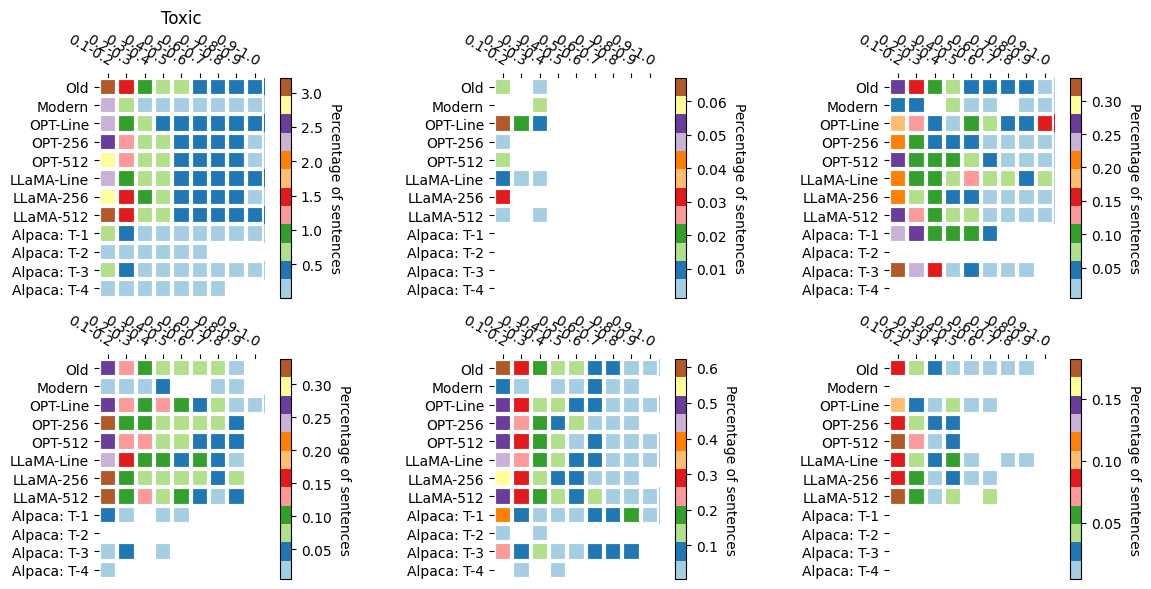

In [116]:
fig, ((ax, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))

mat, y_labels, x_labels = generate_hmaps(label='toxic')
im, _ = heatmap(mat, y_labels, x_labels, ax=ax, cmap="Paired", cbarlabel="Percentage of sentences")
ax.set_title('Toxic')

mat, y_labels, x_labels = generate_hmaps(label='severe_toxic')
im, _ = heatmap(mat, y_labels, x_labels, ax=ax2, cmap="Paired", cbarlabel="Percentage of sentences")

mat, y_labels, x_labels = generate_hmaps(label='obscene')
im, _ = heatmap(mat, y_labels, x_labels, ax=ax3, cmap="Paired", cbarlabel="Percentage of sentences")

mat, y_labels, x_labels = generate_hmaps(label='threat')
im, _ = heatmap(mat, y_labels, x_labels, ax=ax4, cmap="Paired", cbarlabel="Percentage of sentences")

mat, y_labels, x_labels = generate_hmaps(label='insult')
im, _ = heatmap(mat, y_labels, x_labels, ax=ax5, cmap="Paired", cbarlabel="Percentage of sentences")

mat, y_labels, x_labels = generate_hmaps(label='identity_hate')
im, _ = heatmap(mat, y_labels, x_labels, ax=ax6, cmap="Paired", cbarlabel="Percentage of sentences")

plt.tight_layout()
plt.show()

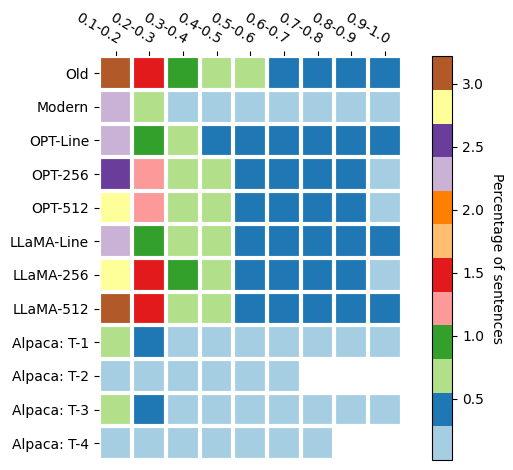

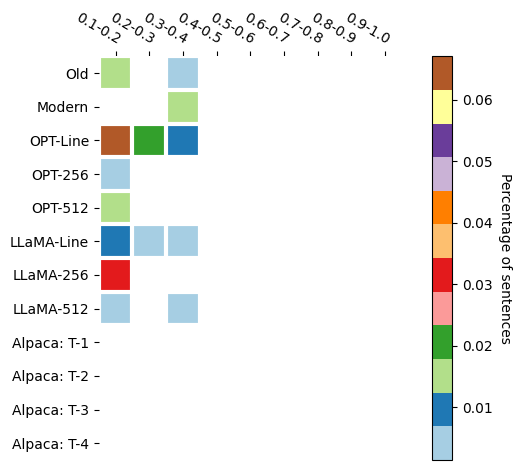

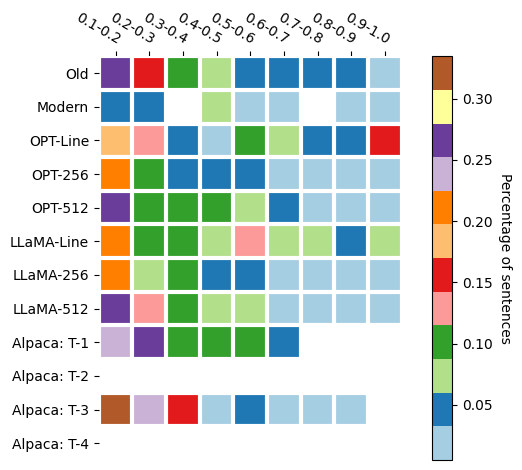

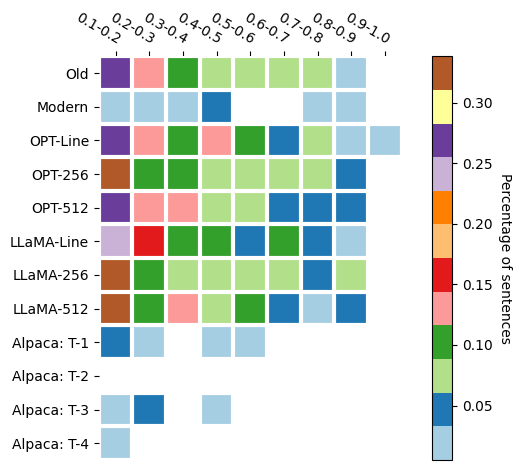

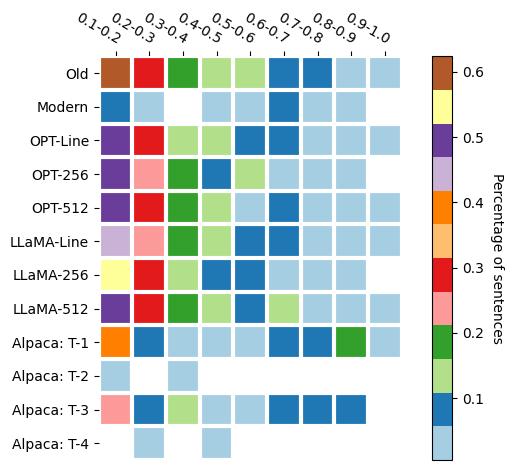

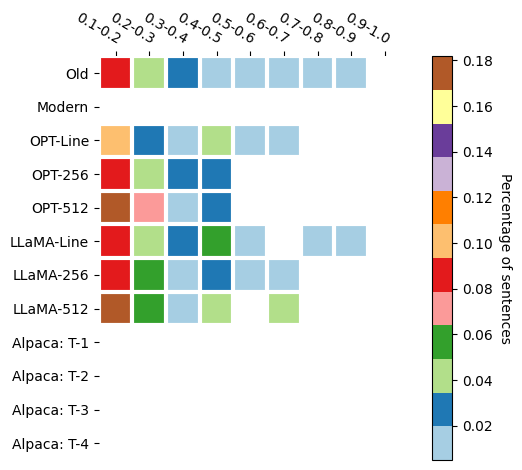

In [124]:
measures = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for m in measures:
    generate_hmaps_and_plot(label=m)

In [ ]:
def get_toxic_measure(label='toxic'):
    mat = np.zeros(())
    print(label)
    print('....')
    bin_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # original
    counts, _ = np.histogram(original[label], bins=bin_labels)
    print(counts)
    print(f'Old Stories: {counts}')

    counts, _ = np.histogram(modern[label], bins=bin_labels)
    print(f'Modern Stories: {counts}')


    counts, _ = np.histogram(opt_first_line[label], bins=bin_labels)
    print(f'OPT-Line: {counts}')
    counts, _ = np.histogram(opt_256_tokens[label], bins=bin_labels)
    print(f'OPT-256: {counts}')
    counts, _ = np.histogram(opt_512_tokens[label], bins=bin_labels)
    print(f'OPT-512: {counts}')

    counts, _ = np.histogram(llama_first_line[label], bins=bin_labels)
    print(f'LLaMA-Line: {counts}')
    counts, _ = np.histogram(llama_256_tokens[label], bins=bin_labels)
    print(f'LLaMA-256: {counts}')
    counts, _ = np.histogram(llama_512_tokens[label], bins=bin_labels)
    print(f'LLaMA-512: {counts}')

    counts, _ = np.histogram(alpaca_1[label], bins=bin_labels)
    print(f'Alpaca: T1: {counts}')
    counts, _ = np.histogram(alpaca_free_2[label], bins=bin_labels)
    print(f'Alpaca: T2: {counts}')
    counts, _ = np.histogram(alpaca_3[label], bins=bin_labels)
    print(f'Alpaca: T3: {counts}')
    counts, _ = np.histogram(alpaca_free_4[label], bins=bin_labels)
    print(f'Alpaca: T4: {counts}')
    print('##############')


In [ ]:
get_toxic_measure('severe_toxic')

In [ ]:
measures = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for m in measures:
    get_toxic_measure(m)


In [ ]:
get_toxic_measure('severe_toxic')